In [ ]:
#NLTK init
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [ ]:
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix

from textblob import TextBlob

#DataSet

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SentimentAnalysis/tweets.csv', encoding = "ISO-8859-1", names=["sentiment", "ids", "date", "flag", "user", "text"])

In [ ]:
df

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
df = df.drop(['ids', 'date', 'flag', 'user'], axis = 'columns')
df = df.drop_duplicates(keep = 'first')
print("The size of dataset after removing duplicates is : ", len(df))

The size of dataset after removing duplicates is :  1583691


In [ ]:
df['sentiment'] = df['sentiment'].replace(4,1)

Negative Sentiment Tweets Percentage is 49.89515000085244%
Positive Sentiment Tweets Percentage is 50.10484999914756%


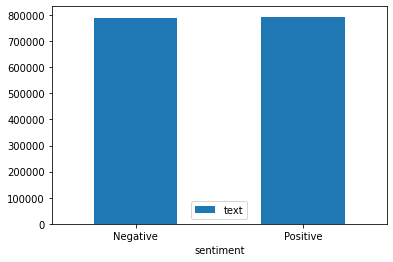

In [ ]:
#Plotting the dataset 
pltbar = df.groupby('sentiment').count().plot(kind='bar')
pltbar.set_xticklabels(['Negative','Positive'], rotation=0)


#Calculating percentages of negative and positive tweets
positiveTweets = 100*len(df.loc[df['sentiment']==1,'sentiment'])/len(df['sentiment'])
negativeTweets = 100*len(df.loc[df['sentiment']==0,'sentiment'])/len(df['sentiment'])
print(f'Negative Sentiment Tweets Percentage is {negativeTweets}%')
print(f'Positive Sentiment Tweets Percentage is {positiveTweets}%')

# Storing data in lists.
text, sentiment = list(df['text']), list(df['sentiment'])

#Preprocessing the Dataset

In [ ]:
df

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
stop_words = stopwords.words('english')
def cleanTweet(text):
    cleanedTweets = []
    
    for tweets in text:
        #Converting text to lowercase
        tweets = tweets.lower()

        #Removing newline breaks
        tweets = re.sub(r'\n', '', tweets)
        
        #Removing URLs
        tweets = re.sub(r"(?:\|http?\://|https?\://|www)\S+", "", tweets)
        
        #Removing @usernames
        tweets = re.sub('@[^\s]+','', tweets)
        
        #Removing punctuations, numbers & special characters
        tweets = re.sub("[^a-zA-Z]", " ", tweets)
        
        #Removing emojis
        tweets = re.compile("["
                   u"U0001F600-U0001F64F"  # emoticons
                   u"U0001F300-U0001F5FF"  # symbols & pictographs
                   u"U0001F680-U0001F6FF"  # transport & map symbols
                   u"U0001F1E0-U0001F1FF"  # flags (iOS)
                   u"U00002702-U000027B0"
                   u"U000024C2-U0001F251"
                               "]+", flags=re.UNICODE).sub(r'', tweets)
        
        finaltweet = ''
        #Removing short words(with length less than 3) & stop words
        temp = tweets.split()
        stop_words = stopwords.words('english')
        stop_words = stop_words + ['hi', 'im', 'amp', 'quot']
        textwithoutstopwords = [word for word in temp if not word in stop_words and len(word)>2]
        
        #Lemmatization
        lem = WordNetLemmatizer()
        lemmatizedText = [lem.lemmatize(y) for y in textwithoutstopwords]
        finaltweet = ' '.join(lemmatizedText)
        cleanedTweets.append(finaltweet)
    return cleanedTweets

In [ ]:
cleanedTweets = cleanTweet(text)
df['Cleaned Tweets'] = cleanedTweets
df

,sentiment,text,Cleaned Tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest bound
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving mad see
...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,woke school best feeling ever
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,thewdb com cool hear old walt interview
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask detail
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,happy birthday boo alll time tupac amaru shakur


#Data Anlysis

####Word Cloud

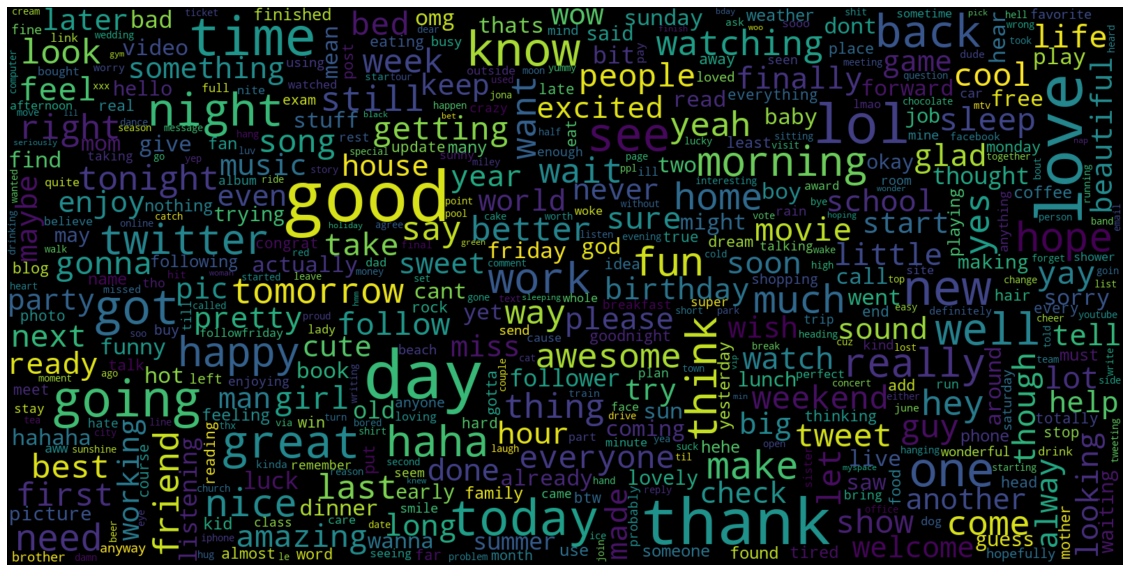

In [ ]:
#Word Cloud Postive Words
all_words = " ".join([tweet for tweet in df['Cleaned Tweets'][df['sentiment']==1]])

wordcloud = WordCloud(max_words = 500, width=1600, height=800, collocations = False, max_font_size=100).generate(all_words)

plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

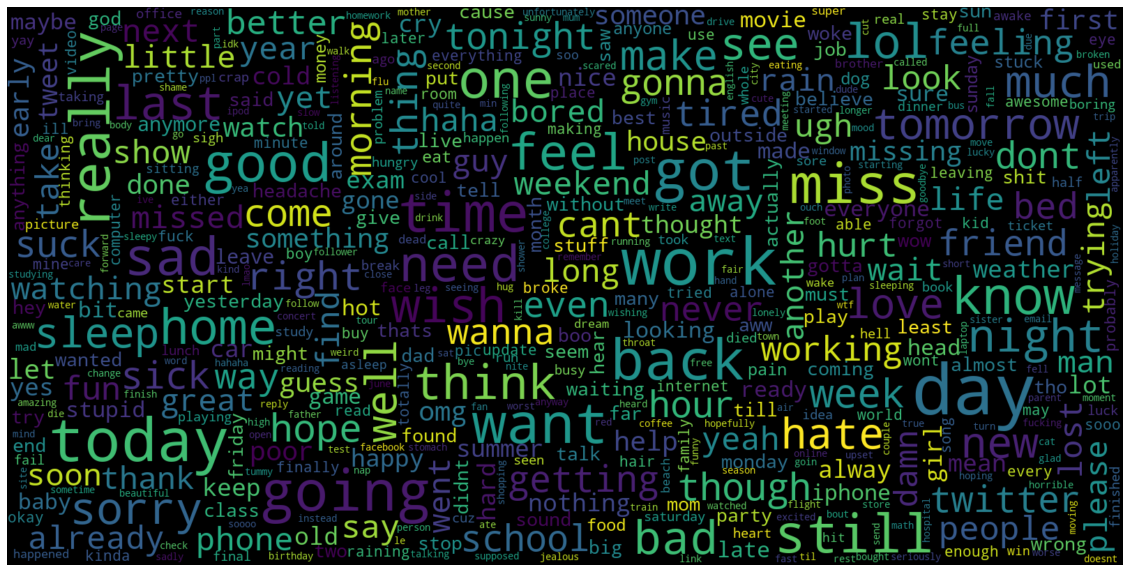

In [ ]:
#Word Clud Negative Words
all_words = " ".join([tweet for tweet in df['Cleaned Tweets'][df['sentiment']==0]])

wordcloud = WordCloud(max_words = 500, width=1600, height=800, collocations = False, max_font_size=100).generate(all_words)

plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##Splitting Data

In [ ]:
X_train,X_test,Y_train, Y_test = train_test_split(text, sentiment, test_size=0.1)
print("Size of training set : ", len(X_train))
print("Size of test set : ", len(X_test))

Size of training set :  1425321
Size of test set :  158370


###TF-IDF Vectorizer

In [ ]:
vectorizer= TfidfVectorizer(ngram_range=(1,2), max_features=500000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

##Calc models accuracies

In [ ]:
def evaluateModel(model):
    
    #Predict values for test dataset
    Y_pred = model.predict(X_test)

    #Print the accuracy score and f1 score
    print("Accuracy = ",accuracy_score(Y_test,Y_pred))
    print("f1-score = ",f1_score(Y_test, Y_pred))
    
    
#Function to plot the confusion matrix    
def plotCF(model):
    Y_pred = model.predict(X_test)
    
    #Plotting the confusion matrix
    cf_matrix = confusion_matrix(Y_test, Y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Negatives','False Positives', 'False Negatives','True Positives']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'YlGnBu',fmt = '',xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

####1. Logistic Regression

Logistic Regression : 
Accuracy =  0.8235208688514238
f1-score =  0.8254049563028255


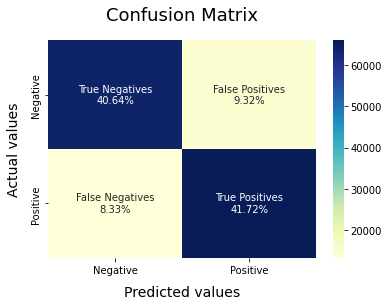

In [ ]:
lr = LogisticRegression(max_iter = 1000, n_jobs=-1)
lr.fit(X_train, Y_train)
print("Logistic Regression : ")
evaluateModel(lr)
plotCF(lr)

####2. Bernoulli Naive Bayes

Bernoulli Naive Bayes Model : 
Accuracy =  0.7978973290395909
f1-score =  0.8002870246154807


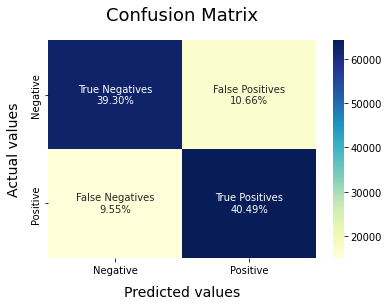

In [ ]:
bnb = BernoulliNB()
bnb.fit(X_train, Y_train)
print("Bernoulli Naive Bayes Model : ")
evaluateModel(bnb)
plotCF(bnb)

####3. Multinomial Naive Bayes

Multinomial Naive Bayes Model : 
Accuracy =  0.8038264822883122
f1-score =  0.8019658086969824


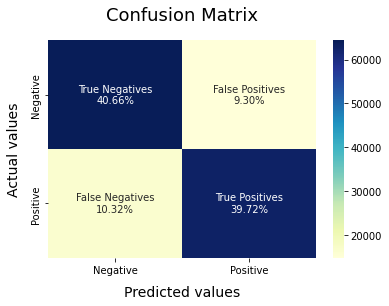

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, Y_train)
print("Multinomial Naive Bayes Model : ")
evaluateModel(mnb)
plotCF(mnb)

####4.Support Vector Machine

Support Vector Machine :
Accuracy =  0.8136894613878891
f1-score =  0.8154052126474894


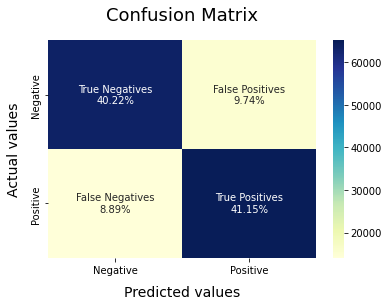

In [ ]:
svm = LinearSVC()
svm.fit(X_train, Y_train)
print("Support Vector Machine :")
evaluateModel(svm)
plotCF(svm)